In [127]:
import matplotlib_inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.options.mode.copy_on_write = True
matplotlib_inline.backend_inline.set_matplotlib_formats("svg")
plt.rcParams['font.family'] = 'PingFang HK'

## 讀取資料

In [128]:
df = pd.read_excel("../Online_Retail001.xlsx")
df.shape

(10000, 8)

df.head()

In [129]:
df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,10000.000000,10000,10000.000000,7526.000000
mean,10.158300,2011-07-02 06:06:49.842000128,3.881760,15266.947250
min,-600.000000,2010-12-01 08:45:00,0.000000,12347.000000
25%,1.000000,2011-03-24 13:10:00,1.250000,13908.000000
50%,3.000000,2011-07-15 14:05:00,2.080000,15128.000000
75%,12.000000,2011-10-17 15:06:15,4.130000,16759.000000
max,4000.000000,2011-12-09 12:50:00,736.380000,18283.000000
std,57.905129,NaN,14.863321,1704.574949


發現 `Quantity` 有負值，`CustomerID` 有空值

## 資料清理

### 處理 `Quantity` 負值

In [130]:
df = df[df["Quantity"] > 0]

### 處理 `CustomerID` 空值問題

計算空值個數。

In [131]:
df["CustomerID"].isnull().sum()

np.int64(2442)

刪除 customerid 中的空值。

In [132]:
df.dropna(subset=["CustomerID"], inplace=True)

In [133]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536370,22726,ALARM CLOCK BAKELIKE GREEN,12,2010-12-01 08:45:00,3.75,12583.0,France
1,536375,71053,WHITE METAL LANTERN,6,2010-12-01 09:32:00,3.39,17850.0,United Kingdom
2,536381,21934,SKULL SHOULDER BAG,10,2010-12-01 09:41:00,1.65,15311.0,United Kingdom
3,536381,47580,TEA TIME DES TEA COSY,2,2010-12-01 09:41:00,2.55,15311.0,United Kingdom
4,536384,22424,ENAMEL BREAD BIN CREAM,8,2010-12-01 09:53:00,10.95,18074.0,United Kingdom


### 計算 Sales

In [134]:
df["Sales"] = df["Quantity"] * df["UnitPrice"]

In [135]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales
0,536370,22726,ALARM CLOCK BAKELIKE GREEN,12,2010-12-01 08:45:00,3.75,12583.0,France,45.00
1,536375,71053,WHITE METAL LANTERN,6,2010-12-01 09:32:00,3.39,17850.0,United Kingdom,20.34
2,536381,21934,SKULL SHOULDER BAG,10,2010-12-01 09:41:00,1.65,15311.0,United Kingdom,16.50
3,536381,47580,TEA TIME DES TEA COSY,2,2010-12-01 09:41:00,2.55,15311.0,United Kingdom,5.10
4,536384,22424,ENAMEL BREAD BIN CREAM,8,2010-12-01 09:53:00,10.95,18074.0,United Kingdom,87.60


## 資料分析

## 計算每個顧客的 RFM 資料

抓出 InvoiceDate 的最大值。

In [136]:
maximum = df["InvoiceDate"].max()

maximum

Timestamp('2011-12-09 12:50:00')

為了簡化接下來的操作，假設今天是 2011-12-31。

In [137]:
from datetime import datetime


today = datetime(2011, 12, 31)

計算每個客戶的 RFM。

In [138]:
summary_df = df.groupby("CustomerID").agg(
    Recency=("InvoiceDate", lambda x: (today - x.max())),
    Frequency=("InvoiceNo", "nunique"),
    Monetary=("Sales", "sum"),
)

summary_df

,Recency,Frequency,Monetary
CustomerID,,,
12347.0,23 days 08:08:00,2,28.20
12348.0,96 days 10:47:00,1,40.00
12349.0,39 days 14:09:00,1,339.00
12352.0,93 days 09:02:00,2,36.60
12354.0,253 days 10:49:00,1,23.40
...,...,...,...
18261.0,116 days 14:26:00,1,17.00
18263.0,46 days 15:00:00,2,40.32
18265.0,93 days 09:50:00,1,15.90


In [139]:
summary_df["Recency"].dtype

dtype('<m8[ns]')

把 Recency 轉成天數。

In [140]:
summary_df["Recency"] = summary_df["Recency"].dt.days

summary_df

,Recency,Frequency,Monetary
CustomerID,,,
12347.0,23,2,28.20
12348.0,96,1,40.00
12349.0,39,1,339.00
12352.0,93,2,36.60
12354.0,253,1,23.40
...,...,...,...
18261.0,116,1,17.00
18263.0,46,2,40.32
18265.0,93,1,15.90


## K-means 自訂組數分群

將數值標準化。K-means 前最好將特徵值先標準化，免得各值差異大，分群會被值大的特徵值拉走。

In [141]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [142]:
scale = StandardScaler()

normalized_df = pd.DataFrame(scale.fit_transform(summary_df), columns=summary_df.columns)

normalized_df

,Recency,Frequency,Monetary
0,-1.064554,-0.064058,-0.151695
1,-0.378052,-0.368042,-0.102144
2,-0.914088,-0.368042,1.153423
3,-0.406265,-0.064058,-0.116422
4,1.098398,-0.368042,-0.171851
...,...,...,...
2363,-0.189969,-0.368042,-0.198726
2364,-0.848259,-0.064058,-0.100800
2365,-0.406265,-0.368042,-0.203345
2366,-0.660176,-0.064058,0.092364


先分四群看結果。

In [143]:
kmeans = KMeans(n_clusters=4).fit(normalized_df)

標籤：

In [144]:
kmeans.labels_

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [145]:
kmeans.cluster_centers_

array([[-6.24602327e-01,  8.85156267e-02,  3.97239175e-03],
       [-8.44497526e-01,  3.15818027e+00,  1.66445098e+01],
       [ 1.25366790e+00, -2.90601320e-01, -1.36698236e-01],
       [-1.07395859e+00,  1.86310017e+01,  4.59892599e+00]])

還原標準化後的值，找出各群中心點，可與上面標準化後的值比較

In [146]:
customer_center_reverse = pd.DataFrame(scale.inverse_transform(kmeans.cluster_centers_))
customer_center_reverse.columns = ['monetary_center', 'frequency_center', 'recency_center']

customer_center_reverse

,monetary_center,frequency_center,recency_center
0,69.782803,2.501911,65.270548
1,46.400000,12.600000,4028.038000
2,269.510773,1.254753,31.771331
3,22.000000,63.500000,1159.510000


加入各群標籤以及計算各群個數。

In [147]:
four_cluster_df = summary_df[['Monetary', 'Frequency', 'Recency']].copy()
four_cluster_df['Cluster'] = kmeans.labels_
four_cluster_df.groupby('Cluster')['Monetary'].count()

four_cluster_df

,Monetary,Frequency,Recency,Cluster
CustomerID,,,,
12347.0,28.20,2,23,0
12348.0,40.00,1,96,0
12349.0,339.00,1,39,0
12352.0,36.60,2,93,0
12354.0,23.40,1,253,2
...,...,...,...,...
18261.0,17.00,1,116,0
18263.0,40.32,2,46,0
18265.0,15.90,1,93,0


# 繪圖 scatter

四群中心點（`x` 為 `frequency`、`y` 為 `monetary` 未標準化後的數值） 

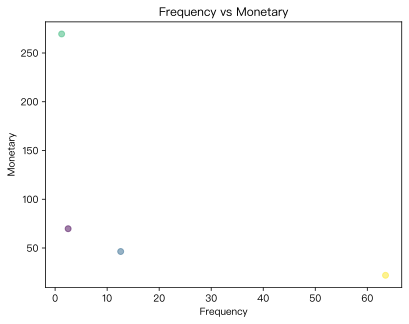

In [148]:
plt.scatter(
    customer_center_reverse["frequency_center"],
    customer_center_reverse["monetary_center"],
    c=customer_center_reverse.index, # 用不同顏色表示不同群組
    alpha=0.5,
)

plt.xlabel("Frequency")
plt.ylabel("Monetary")
plt.title("Frequency vs Monetary")
plt.show()

驗算中心點。

In [149]:
four_cluster_df.groupby('Cluster').mean()

,Monetary,Frequency,Recency
Cluster,,,
0,65.231904,2.500955,69.841502
1,4028.038000,12.600000,46.400000
2,31.805863,1.255076,269.647208
3,1159.510000,63.500000,22.000000


# 繪圖 clusters

## Monetary v. Freqency

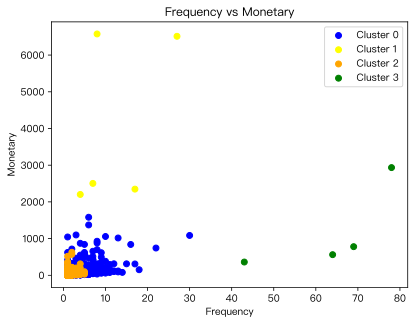

In [150]:
for i in range(4):
    plt.scatter(four_cluster_df[four_cluster_df['Cluster'] == i]['Frequency'], four_cluster_df[four_cluster_df['Cluster'] == i]['Monetary'], label=f'Cluster {i}', c=["blue", "yellow", "orange", "green"][i])

plt.xlabel("Frequency")
plt.ylabel("Monetary")
plt.title("Frequency vs Monetary")
plt.legend()

plt.show()

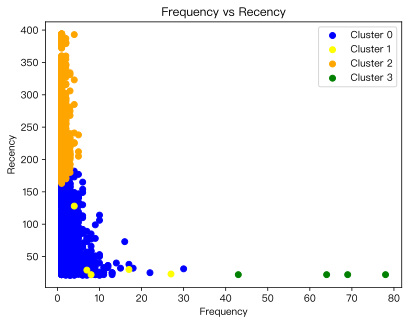

In [151]:
for i in range(4):
    plt.scatter(four_cluster_df[four_cluster_df['Cluster'] == i]['Frequency'], four_cluster_df[four_cluster_df['Cluster'] == i]['Recency'], label=f'Cluster {i}', c=["blue", "yellow", "orange", "green"][i])

plt.xlabel("Frequency")
plt.ylabel("Recency")
plt.title("Frequency vs Recency")
plt.legend()

plt.show()

## 最適分群，根據 Silhouette 值來決定

輪廓係數法的概念是「找出同群資料點內最近/不同群越分散」的值，也就是滿足 Cluster 的定義。

- $b$ 為不同群之間的點平均距離，
- $a$ 為同群之間的距離。

$S$ 則越大越好，代表分得越清楚。


In [152]:
from sklearn.metrics import silhouette_score

In [153]:
for n in range(4, 9):
    kmeans = KMeans(n_clusters=n).fit(normalized_df)
    silhouette_avg = silhouette_score(normalized_df, kmeans.labels_)

    print(f"n_clusters: {n}, silhouette_score: {silhouette_avg}")

n_clusters: 4, silhouette_score: 0.5422735431686179
n_clusters: 5, silhouette_score: 0.4722589301976395
n_clusters: 6, silhouette_score: 0.4700131520493287
n_clusters: 7, silhouette_score: 0.48012498287742655
n_clusters: 8, silhouette_score: 0.4799776351688932


根據 Silhouette 值，5 群最適合。

In [154]:
kmeans = KMeans(n_clusters=5).fit(normalized_df)

five_clusters_df = summary_df[['Monetary', 'Frequency', 'Recency']].copy()
five_clusters_df['Cluster'] = kmeans.labels_

five_clusters_df

,Monetary,Frequency,Recency,Cluster
CustomerID,,,,
12347.0,28.20,2,23,1
12348.0,40.00,1,96,1
12349.0,339.00,1,39,1
12352.0,36.60,2,93,1
12354.0,23.40,1,253,0
...,...,...,...,...
18261.0,17.00,1,116,1
18263.0,40.32,2,46,1
18265.0,15.90,1,93,1


找出各群的中心點。

In [155]:
five_cluster_center = kmeans.cluster_centers_

five_cluster_center

array([[ 1.28987153, -0.28804632, -0.13516365],
       [-0.57840031, -0.12060269, -0.09950856],
       [-1.07395859, 18.63100165,  4.59892599],
       [-0.84449753,  3.15818027, 16.64450983],
       [-0.79973026,  1.39564254,  0.65624761]])

還原標準化後的值。找出各群中心點，可以與上面標準化後的值比較。

In [156]:
five_cluster_center_reverse = pd.DataFrame(scale.inverse_transform(five_cluster_center))
five_cluster_center_reverse.columns = ['monetary_center', 'frequency_center', 'recency_center']

five_cluster_center_reverse

,monetary_center,frequency_center,recency_center
0,273.360526,1.263158,32.136776
1,74.695746,1.813987,40.627658
2,22.000000,63.500000,1159.510000
3,46.400000,12.600000,4028.038000
4,51.160377,6.801887,220.602972


### 問題：找出各群個數

In [157]:
five_clusters_df.groupby('Cluster')['Monetary'].count().to_frame()

,Monetary
Cluster,
0,760
1,1387
2,4
3,5
4,212


## 匯出圖片

匯出五群的圖，X 軸為 frequency, y 軸為 recency，並標示出中心點。以下繪圖法可與上面繪圖法做比較。

Text(0, 0.5, 'Recency')

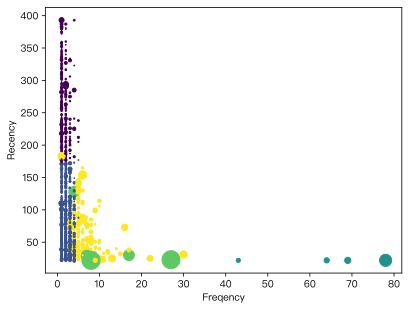

In [158]:
plt.scatter(
    five_clusters_df["Frequency"],
    five_clusters_df["Recency"],
    c=five_clusters_df['Cluster'],
    s=five_clusters_df['Monetary'] / 20,
)

plt.xlabel("Freqency")
plt.ylabel("Recency")

各群中心點。

In [159]:
five_cluster_center_reverse['label'] = five_cluster_center_reverse.index.map(lambda x: f'Cluster {x}')
five_cluster_center_reverse

,monetary_center,frequency_center,recency_center,label
0,273.360526,1.263158,32.136776,Cluster 0
1,74.695746,1.813987,40.627658,Cluster 1
2,22.000000,63.500000,1159.510000,Cluster 2
3,46.400000,12.600000,4028.038000,Cluster 3
4,51.160377,6.801887,220.602972,Cluster 4


Text(0.5, 1.0, 'Frequency vs Recency Clusters-by-best Cluster')

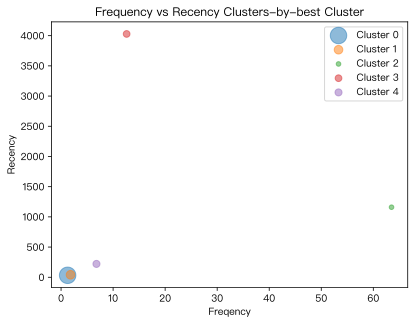

In [171]:
five_cluster_center_reverse['label'] = five_cluster_center_reverse.index.map(lambda x: f'Cluster {x}')

for i in five_cluster_center_reverse.index:
    plt.scatter(
        five_cluster_center_reverse.loc[i, 'frequency_center'],
        five_cluster_center_reverse.loc[i, 'recency_center'],
        s=five_cluster_center_reverse.loc[i, 'monetary_center'],
        alpha=0.5,
        label=f'Cluster {i}',
    )

plt.xlabel("Freqency")
plt.ylabel("Recency")
plt.legend()

plt.title("Frequency vs Recency Clusters-by-best Cluster")

# 分群後之各群產品推薦

## 最有價值群別顧客編號與購買產品清單

確定最有價值群別，結果發現第二群，因此找出第二群 top5 產品名稱

WIP:

```python
#分群後之各群產品推薦
#最有價值群別顧客編號與購買產品清單

#tt
five_cluster_center

df_original = pd.read_excel('Online_Retail001.xlsx') 

#第二群的顧客編號
second_cluster_ID=five_cluster_df.loc[five_cluster_df['Cluster'] == 2].index

#第二群的顧客全部資料
second_cluster=df_original[df_original['CustomerID'].isin(second_cluster_ID)]


#第二群銷售商品前五名產品
top5=second_cluster.groupby('StockCode')['Description'].count().sort_values(ascending=False).head()

print(top5)

#針對分群的某一群的個別顧客推薦商品:#第二群個別顧客的產品建議

#挑選第二群
##第二群的顧客編號
second_cluster_ID=five_cluster_df.loc[five_cluster_df['Cluster'] == 2].index

##第二群的顧客全部資料
second_cluster=df_original[df_original['CustomerID'].isin(second_cluster_ID)]

#轉置顧客編號與產品
second_cluster_item_matrix =second_cluster.pivot_table(
     index='StockCode', 
     columns='CustomerID', 
     values='Quantity',
     aggfunc='sum'
 )

second_cluster_item_matrix

#列出群內每個顧客購買的產品清單
###1.列出群內顧客編號 2.列出每位顧客購買產品

recom_list = [] #存放某顧客購買過的商品
second_cluster_cliendid=[] #存放某顧客編號

for i in second_cluster_item_matrix.columns:
    aa = second_cluster_item_matrix[i].rank().sort_values(ascending = False) #挑選某顧客在每個產品購買情況
    aa.dropna(inplace=True)
    recom_list.append('、'.join((aa.index).astype(str)))
    second_cluster_cliendid.append(i)

second_cluster_cliendid
recom_list


###結合顧客編號與顧客產品,將second_cluster_cliendid,recom_list申連起來，形成一個DataFrame, 並將結果存為seccustomer_recomm1.csv
second_cluster_recomm1=pd.DataFrame(zip(second_cluster_cliendid,recom_list)) 
second_cluster_recomm1.to_csv('seccustomer_recomm1.csv', encoding = 'cp950')   
```